<a href="https://colab.research.google.com/github/jnbellefuil/waste-classifier/blob/main/Final_Project_RealWaste_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data.sampler import WeightedRandomSampler
from collections import Counter
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
from sklearn.metrics import classification_report

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jinahbellefuil","key":"064d55c7a13787fbfa1dcfeba03ece30"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the RealWaste dataset
!kaggle datasets download -d joebeachcapital/realwaste

# Unzip the dataset
!unzip realwaste.zip -d realwaste

Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/realwaste
License(s): Attribution 4.0 International (CC BY 4.0)
Archive:  realwaste.zip
  inflating: realwaste/realwaste-main/README.md  
  inflating: realwaste/realwaste-main/RealWaste/Cardboard/Cardboard_1.jpg  
  inflating: realwaste/realwaste-main/RealWaste/Cardboard/Cardboard_10.jpg  
  inflating: realwaste/realwaste-main/RealWaste/Cardboard/Cardboard_100.jpg  
  inflating: realwaste/realwaste-main/RealWaste/Cardboard/Cardboard_101.jpg  
  inflating: realwaste/realwaste-main/RealWaste/Cardboard/Cardboard_102.jpg  
  inflating: realwaste/realwaste-main/RealWaste/Cardboard/Cardboard_103.jpg  
  inflating: realwaste/realwaste-main/RealWaste/Cardboard/Cardboard_104.jpg  
  inflating: realwaste/realwaste-main/RealWaste/Cardboard/Cardboard_105.jpg  
  inflating: realwaste/realwaste-main/RealWaste/Cardboard/Cardboard_106.jpg  
  inflating: realwaste/realwaste-main/RealWaste/Cardboard/Cardboard_107.jpg  
  inflating: realwaste/r

In [ ]:
os.listdir('realwaste')

['realwaste-main']

In [ ]:
class RealWasteDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_realwaste_data(base_dir, img_size):
    data = []
    labels = []
    class_names = sorted(os.listdir(base_dir))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

    for cls_name in class_names:
        cls_dir = os.path.join(base_dir, cls_name)
        if not os.path.isdir(cls_dir):
            continue
        for imgname in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, imgname)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            data.append(img)
            labels.append(class_to_idx[cls_name])

    return np.array(data), np.array(labels), class_names

In [ ]:
data, labels, classes = load_realwaste_data('realwaste/realwaste-main/RealWaste', img_size=(64, 64))

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = RealWasteDataset(X_train, y_train, transform=train_transform)
test_dataset = RealWasteDataset(X_test, y_test, transform=test_transform)

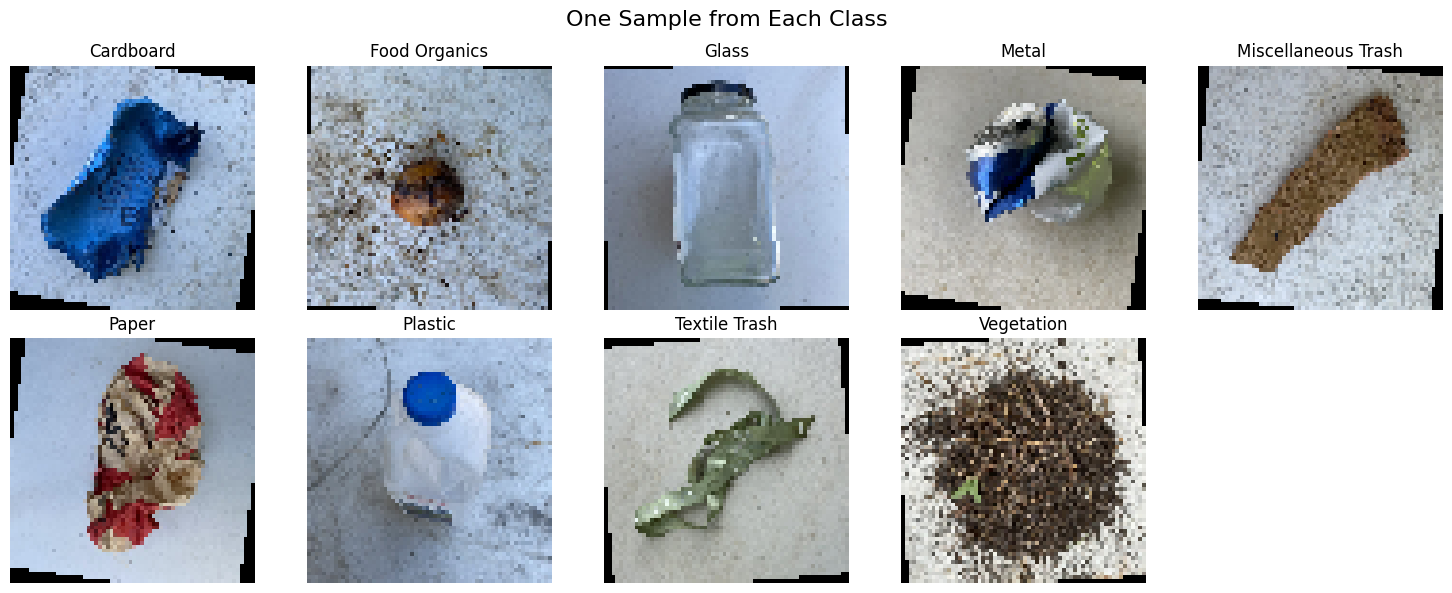

In [ ]:
import matplotlib.pyplot as plt

def show_sample_images_by_class(dataset, class_names):
    seen_classes = set()
    images_by_class = {}

    # Collect one image per class
    for img, label in dataset:
        class_idx = label.item() if torch.is_tensor(label) else label
        if class_idx not in seen_classes:
            images_by_class[class_idx] = img
            seen_classes.add(class_idx)
        if len(seen_classes) == len(class_names):
            break

    # Plot images
    plt.figure(figsize=(15, 6))
    for idx, class_idx in enumerate(sorted(images_by_class.keys())):
        img = images_by_class[class_idx]
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = (img * 0.5) + 0.5     # Unnormalize from [-1, 1] to [0, 1]
        img = img.numpy()
        plt.subplot(2, 5, idx + 1)
        plt.imshow(img)
        plt.title(class_names[class_idx])
        plt.axis('off')

    plt.suptitle('One Sample from Each Class', fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the function using your train_dataset and class list
show_sample_images_by_class(train_dataset, classes)


Class Distribution:
Cardboard: 461 images
Food Organics: 411 images
Glass: 420 images
Metal: 790 images
Miscellaneous Trash: 495 images
Paper: 500 images
Plastic: 921 images
Textile Trash: 318 images
Vegetation: 436 images


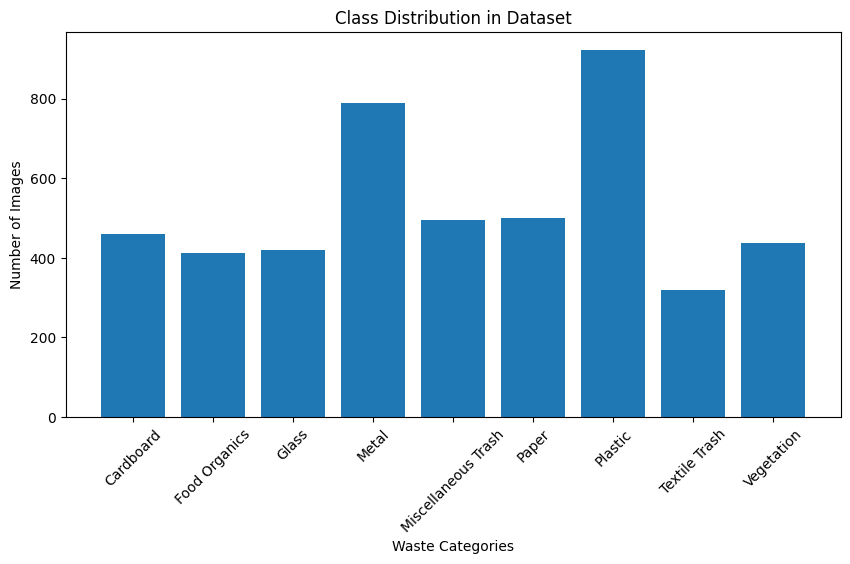

In [ ]:
import os
from collections import defaultdict

def get_class_counts(base_dir):
    class_counts = defaultdict(int)
    class_names = sorted(os.listdir(base_dir))

    for cls_name in class_names:
        cls_dir = os.path.join(base_dir, cls_name)
        if os.path.isdir(cls_dir):
            count = len(os.listdir(cls_dir))
            class_counts[cls_name] = count

    return class_counts

base_dir = 'realwaste/realwaste-main/RealWaste'
class_counts = get_class_counts(base_dir)

print("Class Distribution:")
for cls, count in sorted(class_counts.items()):
    print(f"{cls}: {count} images")

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution in Dataset')
plt.xlabel('Waste Categories')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [ ]:

# Count number of samples per class in the training set
class_counts = Counter(y_train)
num_classes = len(classes)

# Compute weight for each class: inverse of frequency
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# Assign a weight to each sample in the training set
sample_weights = [class_weights[label] for label in y_train]

# Convert weights to a tensor
sample_weights_tensor = torch.DoubleTensor(sample_weights)


In [ ]:
batch_size = 32
sampler = WeightedRandomSampler(sample_weights_tensor, num_samples=len(sample_weights_tensor), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Count number of samples per class in the training set
class_counts = Counter(y_train)
num_classes = len(classes)

# Compute weight for each class: inverse of frequency
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# Assign a weight to each sample in the training set
sample_weights = [class_weights[label] for label in y_train]

# Convert weights to a tensor
sample_weights_tensor = torch.DoubleTensor(sample_weights)

# Ensure num_samples is a multiple of batch_size
num_samples = len(sample_weights_tensor)
num_samples = (num_samples // batch_size) * batch_size  # Adjust num_samples

# Use the adjusted num_samples in the WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights_tensor, num_samples=num_samples, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
kernelList = []
kernelList.append(np.array([[0,0,0],[0,1,0],[0,0,0]], dtype=np.float32))                     # Identity
kernelList.append(np.array([[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]], dtype=np.float32))   # Blur
kernelList.append(np.array([[-2,-1,0],[-1,1,1],[0,1,2]], dtype=np.float32))                  # Emboss
kernelList.append(np.array([[1,1,1],[0,0,0],[-1,-1,-1]], dtype=np.float32))                  # Horizontal edges
kernelList.append(np.array([[1,0,-1],[1,0,-1],[1,0,-1]], dtype=np.float32))                  # Vertical edges

# Convert to torch tensor and expand to shape [out_channels, in_channels, H, W]
kernel_tensors = torch.stack([
    torch.tensor(k).unsqueeze(0).repeat(3, 1, 1) for k in kernelList
]).float()

In [ ]:
class CNN(nn.Module):
    def __init__(self, img_w, img_h, num_kernels, kernel_size, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, num_kernels, kernel_size=kernel_size, padding=1)
        self.bn1 = nn.BatchNorm2d(num_kernels)

        self.conv2 = nn.Conv2d(num_kernels, num_kernels * 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_kernels * 2)

        self.conv3 = nn.Conv2d(num_kernels * 2, num_kernels * 4, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_kernels * 4)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # For 64x64 input: 3 poolings => 8x8 output feature maps
        conv_out_dim = (img_w // 8) * (img_h // 8) * (num_kernels * 4)  # (8*8*num_kernels*4)
        self.fc1 = nn.Linear(conv_out_dim, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> 32x32
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> 16x16
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # -> 8x8
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)


# Helper Functions

In [ ]:
def test(network, test_loader, loss_function):
  network.eval() #updates any network layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

def graphConfusionMatrix(test_datset, num_samples=10000):
  data_generator = torch.utils.data.DataLoader(test_datset, batch_size=num_samples)
  data_enumerator = enumerate(data_generator)
  _, (images,labels) = next(data_enumerator)
  with torch.no_grad():
      pred_catigories = network(images) #all 10 values
      pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
  conf_mat = confusion_matrix(labels.numpy(), pred_labels.numpy(), normalize = "pred")
  plt.figure(figsize=(8,5))
  sns.heatmap(conf_mat, annot=True, fmt="0.2f", xticklabels = classes, yticklabels = classes,
              cmap = "gnuplot") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
  plt.xlabel("Target Class")
  plt.ylabel("Predicted Class")

In [ ]:
def train(network,  data_generator, loss_function, optimizer, batch_logging = 100):
  network.train() #updates any network layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for batch, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = network(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
    if ((batch+1)%batch_logging == 0): #Print info every "batch_logging" steps [NEW]
      print('Batch [%d/%d], Train Loss: %.4f' %(batch+1, len(data_generator.dataset)/len(target_output), avg_loss/num_batches))
  return avg_loss/num_batches

In [ ]:
def trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, early_stopping=True, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []
  last_loss = 999999
  best_loss = 999999
  for epoch in range(num_epochs):
    avg_loss = train(network, training_generator, loss_function, optimizer)
    test_loss = test(network, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
    if (early_stopping and test_loss > last_loss):
      break
    if (test_loss < best_loss):
      best_loss = test_loss
      torch.save(network.state_dict(), 'best_model.pt')
    last_loss = test_loss
    old_params = network.parameters()

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20):
    train_loss_history = []
    test_loss_history = []
    accuracy_history = []

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_loss_history.append(epoch_loss)

        # Test phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_epoch_loss = test_loss / len(test_loader)
        test_loss_history.append(test_epoch_loss)
        accuracy = 100 * correct / total
        accuracy_history.append(accuracy)

        # Adjust learning rate
        scheduler.step(test_epoch_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Test Loss: {test_epoch_loss:.4f}, '
              f'Accuracy: {accuracy:.2f}%, '
              f'LR: {optimizer.param_groups[0]["lr"]:.2e}')

    return train_loss_history, test_loss_history, accuracy_history

# CNN Training and Analysis

Epoch [1/35], Train Loss: 1.8614, Test Loss: 1.5175, Accuracy: 42.69%, LR: 1.00e-03
Epoch [2/35], Train Loss: 1.4849, Test Loss: 1.3728, Accuracy: 48.05%, LR: 1.00e-03
Epoch [3/35], Train Loss: 1.3815, Test Loss: 1.2397, Accuracy: 55.84%, LR: 1.00e-03
Epoch [4/35], Train Loss: 1.2729, Test Loss: 1.0933, Accuracy: 58.15%, LR: 1.00e-03
Epoch [5/35], Train Loss: 1.2121, Test Loss: 1.2730, Accuracy: 50.47%, LR: 1.00e-03
Epoch [6/35], Train Loss: 1.2062, Test Loss: 1.0462, Accuracy: 62.25%, LR: 1.00e-03
Epoch [7/35], Train Loss: 1.1284, Test Loss: 1.0665, Accuracy: 60.25%, LR: 1.00e-03
Epoch [8/35], Train Loss: 1.1177, Test Loss: 1.0134, Accuracy: 63.30%, LR: 1.00e-03
Epoch [9/35], Train Loss: 1.0866, Test Loss: 0.9267, Accuracy: 67.93%, LR: 1.00e-03
Epoch [10/35], Train Loss: 1.0423, Test Loss: 0.9501, Accuracy: 63.83%, LR: 1.00e-03
Epoch [11/35], Train Loss: 1.0401, Test Loss: 0.9579, Accuracy: 64.77%, LR: 1.00e-03
Epoch [12/35], Train Loss: 0.9808, Test Loss: 0.9414, Accuracy: 64.67%, LR

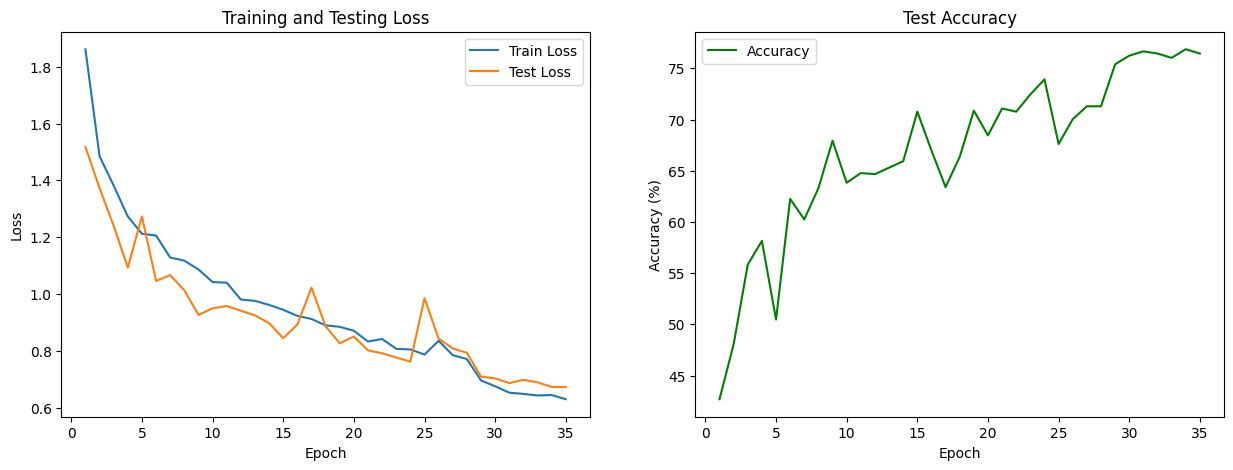

In [ ]:
model = CNN(img_w=64, img_h=64, num_kernels=16, kernel_size=3, num_classes=9)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 35
train_loss, test_loss, accuracy = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), accuracy, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Test Accuracy')
plt.show()


In [ ]:
def graphConfusionMatrix(test_datset, network, num_samples=10000): # Added network as an argument
  data_generator = torch.utils.data.DataLoader(test_datset, batch_size=num_samples)
  data_enumerator = enumerate(data_generator)
  _, (images,labels) = next(data_enumerator)
  with torch.no_grad():
      pred_catigories = network(images) #all 10 values
      pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
  conf_mat = confusion_matrix(labels.numpy(), pred_labels.numpy(), normalize = "pred")
  plt.figure(figsize=(8,5))
  sns.heatmap(conf_mat, annot=True, fmt="0.2f", xticklabels = classes, yticklabels = classes,
              cmap = "gnuplot") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
  plt.xlabel("Target Class")
  plt.ylabel("Predicted Class")

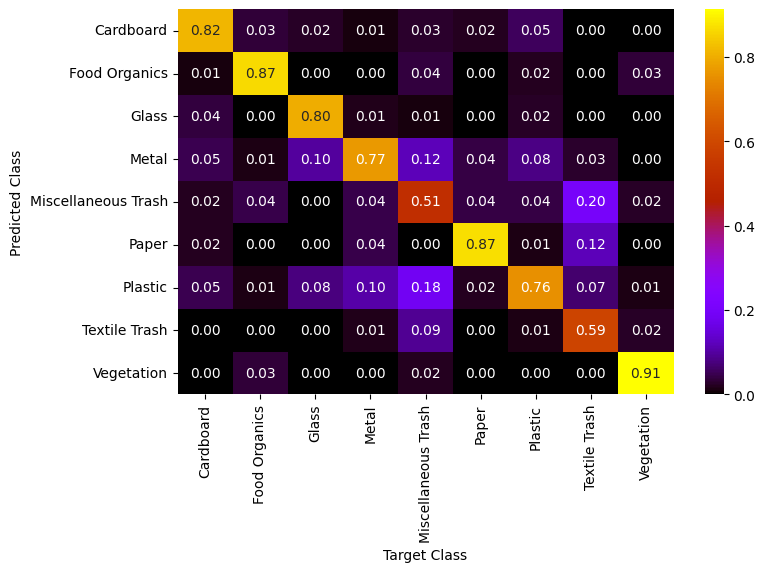

In [ ]:

graphConfusionMatrix(test_dataset, model)

In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=classes))

                     precision    recall  f1-score   support

          Cardboard       0.76      0.78      0.77       166
      Food Organics       0.73      0.86      0.79       133
              Glass       0.83      0.82      0.82       148
              Metal       0.73      0.64      0.68       250
Miscellaneous Trash       0.61      0.56      0.59       168
              Paper       0.75      0.67      0.71       156
            Plastic       0.73      0.68      0.70       296
      Textile Trash       0.57      0.87      0.69       101
         Vegetation       0.88      0.92      0.90       151

           accuracy                           0.73      1569
          macro avg       0.73      0.75      0.74      1569
       weighted avg       0.74      0.73      0.73      1569



# KNN Training and Analysis

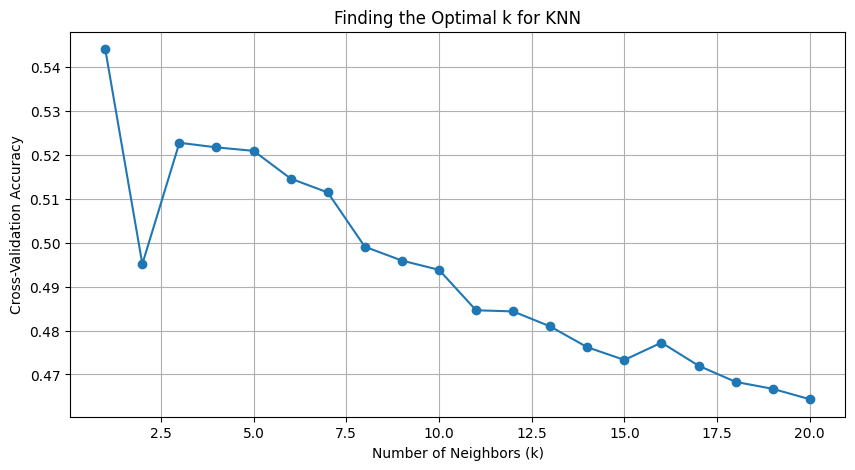

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Flatten and normalize images
X_train_flat = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test_flat = X_test.reshape(X_test.shape[0], -1) / 255.0

# 2. Apply PCA
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# 3. Find best k using cross-validation
k_values = list(range(1, 21))
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_pca, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# 4. Plot k vs. accuracy
plt.figure(figsize=(10, 5))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Finding the Optimal k for KNN")
plt.grid(True)
plt.show()


KNN Accuracy with best k=3: 0.54
                     precision    recall  f1-score   support

          Cardboard       0.57      0.46      0.51       104
      Food Organics       0.42      0.47      0.44        88
              Glass       0.49      0.79      0.60        84
              Metal       0.46      0.64      0.53       150
Miscellaneous Trash       0.48      0.46      0.47        96
              Paper       0.79      0.42      0.55       101
            Plastic       0.62      0.71      0.66       179
      Textile Trash       0.33      0.12      0.17        60
         Vegetation       0.74      0.45      0.56        89

           accuracy                           0.54       951
          macro avg       0.54      0.50      0.50       951
       weighted avg       0.56      0.54      0.53       951



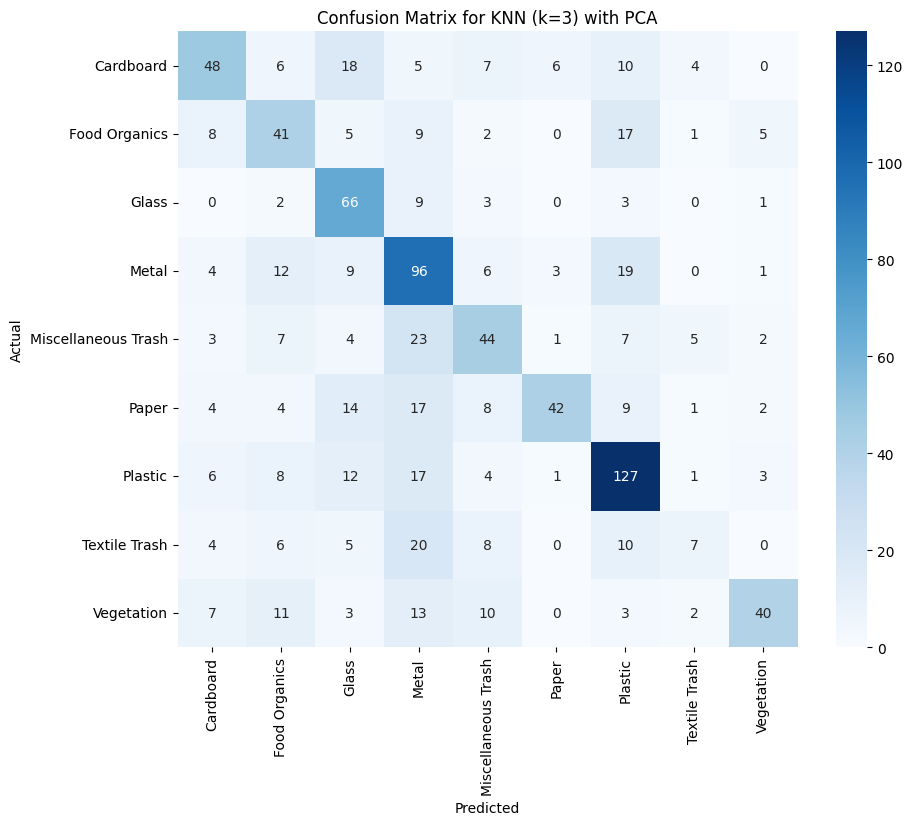

In [ ]:

knn_best = KNeighborsClassifier(n_neighbors=3)
knn_best.fit(X_train_pca, y_train)
y_pred = knn_best.predict(X_test_pca)


acc = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy with best k=3: {acc:.2f}")
print(classification_report(y_test, y_pred, target_names=classes))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for KNN (k=3) with PCA")
plt.show()


# Inception V3 Pretrained Model

In [ ]:
from torchvision import models

train_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # InceptionV3 requirement
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [ ]:
from PIL import Image

class RealWasteDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # ✅ Convert NumPy array to PIL Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
data, labels, classes = load_realwaste_data('realwaste/realwaste-main/RealWaste', img_size=(299, 299))

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

train_dataset = RealWasteDataset(X_train, y_train, transform=train_transform)
test_dataset = RealWasteDataset(X_test, y_test, transform=test_transform)

# Re-create the DataLoaders with the updated datasets
batch_size = 32  # You can adjust this as needed
sampler = WeightedRandomSampler(sample_weights_tensor, num_samples=len(sample_weights_tensor), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def train_inception_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=25, device='cuda'):
    model.to(device)
    train_loss_history = []
    test_loss_history = []
    accuracy_history = []

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Inception returns (main_output, aux_output) during training
            outputs, aux_outputs = model(images)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2  # Combine losses

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_epoch_loss = running_loss / len(train_loader)
        train_loss_history.append(train_epoch_loss)

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)  # Only main output in eval mode
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_epoch_loss = test_loss / len(test_loader)
        test_loss_history.append(test_epoch_loss)

        accuracy = 100 * correct / total
        accuracy_history.append(accuracy)

        scheduler.step(test_epoch_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_epoch_loss:.4f}, '
              f'Test Loss: {test_epoch_loss:.4f}, '
              f'Accuracy: {accuracy:.2f}%')

    return train_loss_history, test_loss_history, accuracy_history


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/25], Train Loss: 1.4076, Test Loss: 1.3801, Accuracy: 57.31%
Epoch [2/25], Train Loss: 0.9917, Test Loss: 0.9107, Accuracy: 69.82%
Epoch [3/25], Train Loss: 0.8260, Test Loss: 0.8580, Accuracy: 70.66%
Epoch [4/25], Train Loss: 0.6984, Test Loss: 0.8458, Accuracy: 74.45%
Epoch [5/25], Train Loss: 0.5931, Test Loss: 0.8022, Accuracy: 76.03%
Epoch [6/25], Train Loss: 0.4760, Test Loss: 0.7679, Accuracy: 76.13%
Epoch [7/25], Train Loss: 0.4250, Test Loss: 0.7861, Accuracy: 76.34%
Epoch [8/25], Train Loss: 0.4002, Test Loss: 0.5167, Accuracy: 84.12%
Epoch [9/25], Train Loss: 0.3755, Test Loss: 0.6819, Accuracy: 78.34%
Epoch [10/25], Train Loss: 0.3400, Test Loss: 0.6964, Accuracy: 78.13%
Epoch [11/25], Train Loss: 0.3489, Test Loss: 0.5250, Accuracy: 83.18%
Epoch [12/25], Train Loss: 0.3000, Test Loss: 0.6770, Accuracy: 80.23%
Epoch [13/25], Train Loss: 0.2065, Test Loss: 0.3543, Accuracy: 88.85%
Epoch [14/25], Train Loss: 0.0958, Test Loss: 0.3372, Accuracy: 89.91%
Epoch [15/25], 

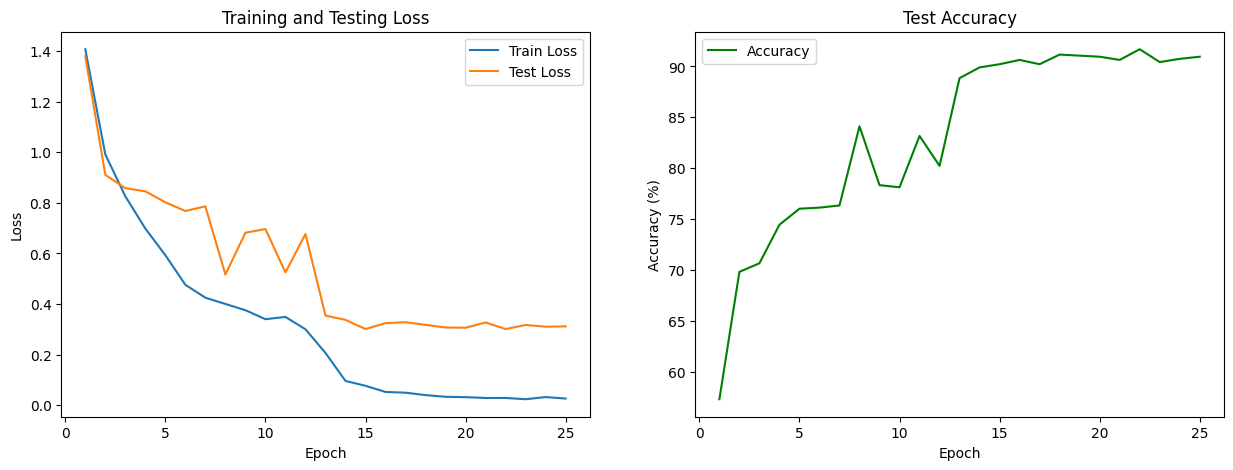

In [ ]:
from torchvision import models

# Load and modify InceptionV3
inception = models.inception_v3(pretrained=True, aux_logits=True)
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, 9)
inception.AuxLogits.fc = nn.Linear(inception.AuxLogits.fc.in_features, 9)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(inception.parameters(), lr=0.001)

# Train the model
num_epochs = 25
train_loss, test_loss, accuracy = train_inception_model(inception, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), accuracy, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Test Accuracy')
plt.show()


                     precision    recall  f1-score   support

          Cardboard       0.95      0.88      0.92       104
      Food Organics       0.89      0.97      0.92        88
              Glass       0.96      0.89      0.93        84
              Metal       0.90      0.92      0.91       150
Miscellaneous Trash       0.85      0.88      0.86        96
              Paper       0.93      0.98      0.95       101
            Plastic       0.90      0.87      0.88       179
      Textile Trash       0.91      0.88      0.90        60
         Vegetation       0.92      0.94      0.93        89

           accuracy                           0.91       951
          macro avg       0.91      0.91      0.91       951
       weighted avg       0.91      0.91      0.91       951



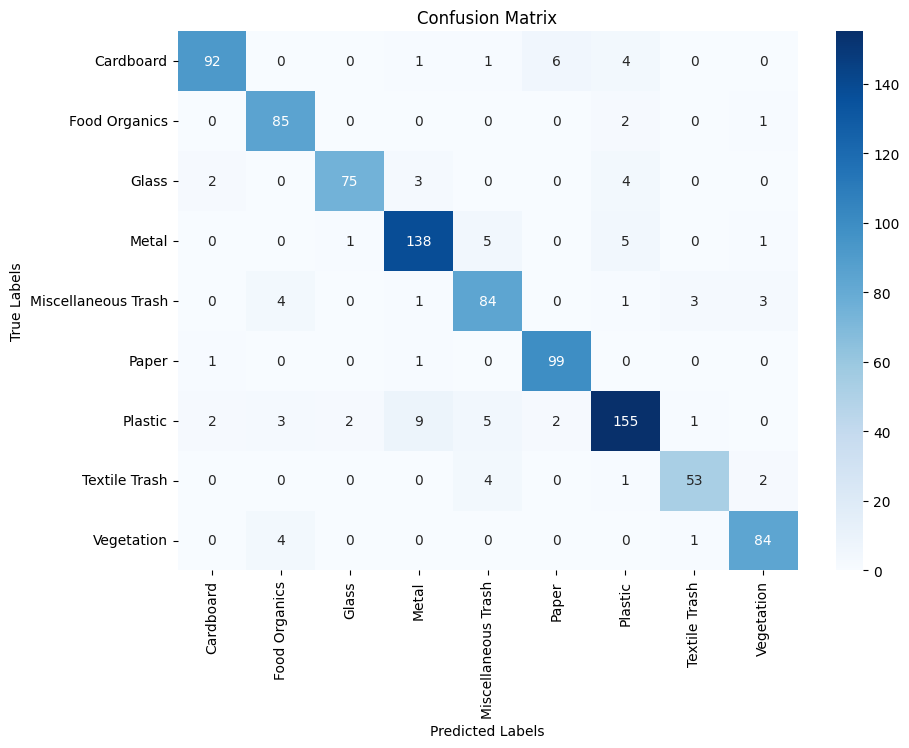

In [ ]:
# Assuming 'test_loader' is a DataLoader and 'inception' is your model
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Define device

# Move model to the correct device
inception = inception.to(device)

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
        outputs = inception(images)
        _, preds = torch.max(outputs, 1)

        # Convert preds and labels back to CPU for further processing
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
print(classification_report(all_labels, all_preds, target_names=classes))

# For confusion matrix, ensure that test_dataset is processed similarly
def graphConfusionMatrix(test_loader, model):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Now plot confusion matrix (you can use libraries like sklearn for this)
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Call the function to display confusion matrix
graphConfusionMatrix(test_loader, inception)